In [1]:
from datetime import timedelta, datetime
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

import random
import pickle
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 50)

# 일수 계산
import calendar

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import cosine_similarity

SEED = 42

def seed_all(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

seed_all(SEED)

### 데이터 로드 및 전처리

In [9]:
seed_all(SEED)

fin_data_df = pd.read_csv('./New_Data/MES_data_argumentation_with_outliers_5462ea.csv')
drop_features = ['ID', 'Date', '호기', '출탕시간', '홀딩로투입시간', 'month', 'day', '출탕_hour', '출탕_minute', '출탕_sec', '투입_hour', '투입_minute', '투입_sec']
print(f'Drop: {drop_features}')
fin_data_df.drop(columns=drop_features, inplace=True)

ori_data_df = fin_data_df[fin_data_df['type']=='Original'].reset_index(drop=True)
ori_data_df.drop(columns=['type'], inplace=True)
gen_nor_df = fin_data_df[fin_data_df['type']=='Normal'].reset_index(drop=True)
gen_nor_df.drop(columns=['type'], inplace=True)
gen_out_df = fin_data_df[fin_data_df['type']=='Outlier'].reset_index(drop=True)
gen_out_df.drop(columns=['type'], inplace=True)

Drop: ['ID', 'Date', '호기', '출탕시간', '홀딩로투입시간', 'month', 'day', '출탕_hour', '출탕_minute', '출탕_sec', '투입_hour', '투입_minute', '투입_sec']


### 데이터 분포 시각화

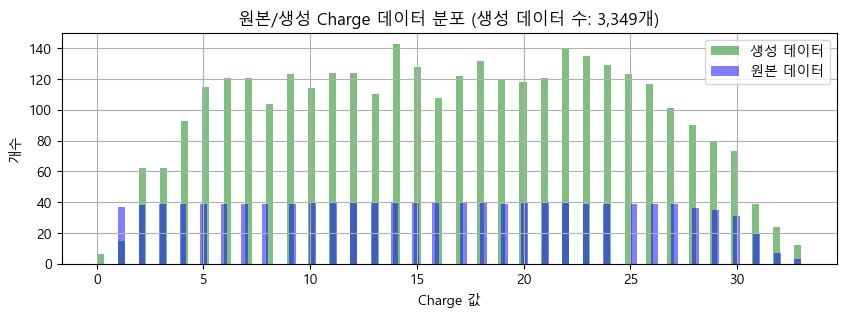

<Figure size 640x480 with 0 Axes>

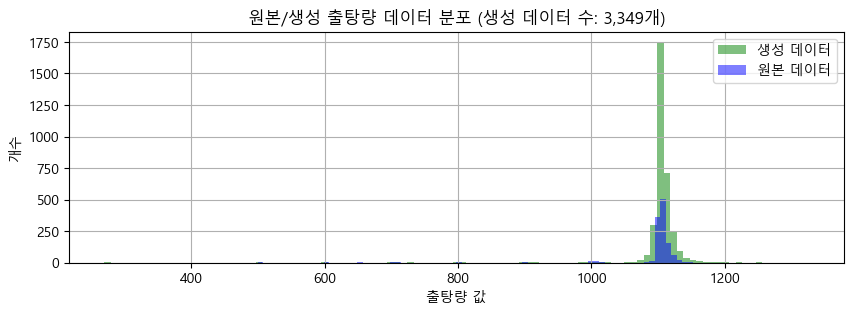

<Figure size 640x480 with 0 Axes>

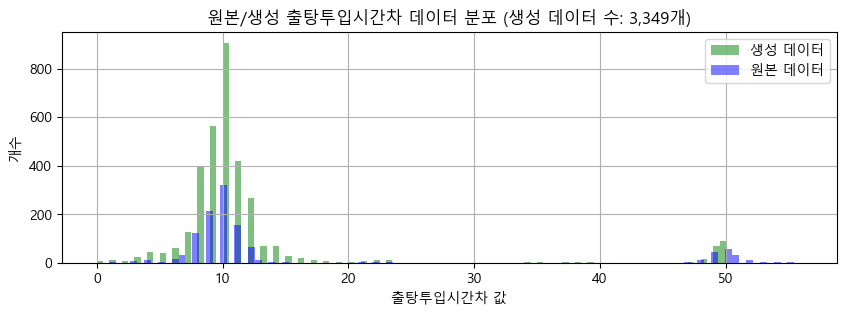

<Figure size 640x480 with 0 Axes>

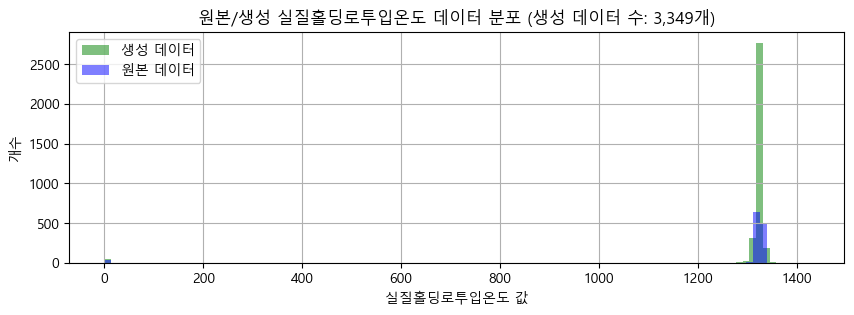

<Figure size 640x480 with 0 Axes>

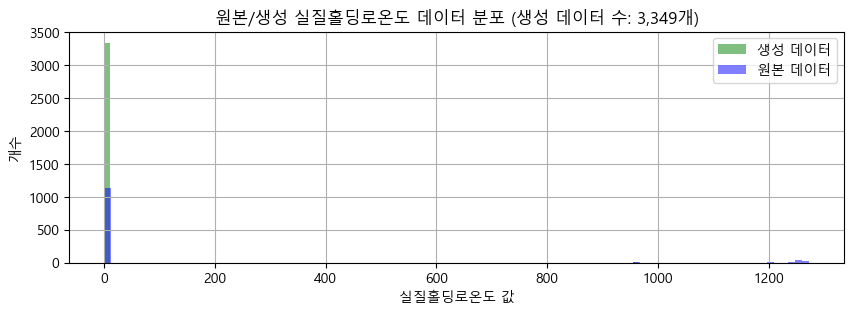

<Figure size 640x480 with 0 Axes>

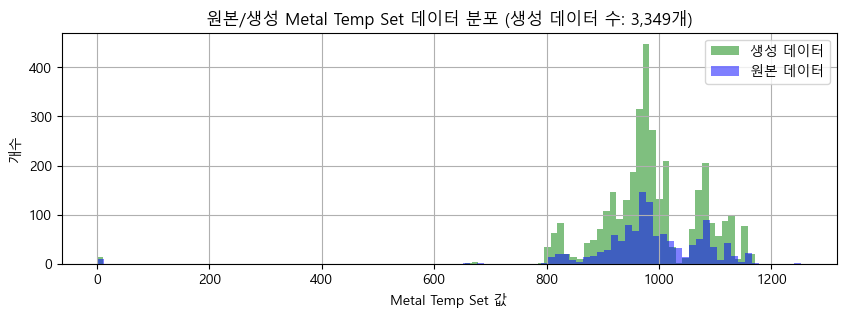

<Figure size 640x480 with 0 Axes>

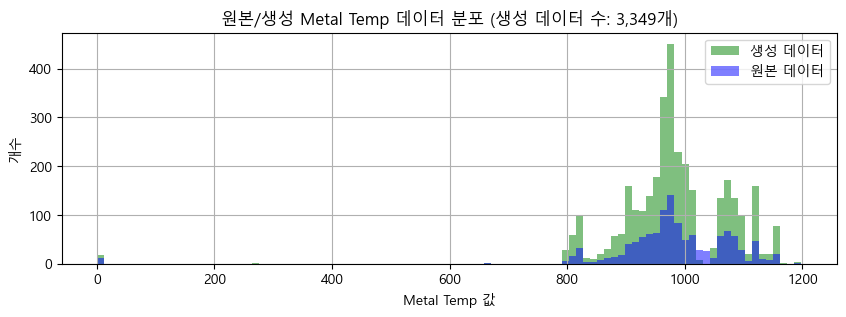

<Figure size 640x480 with 0 Axes>

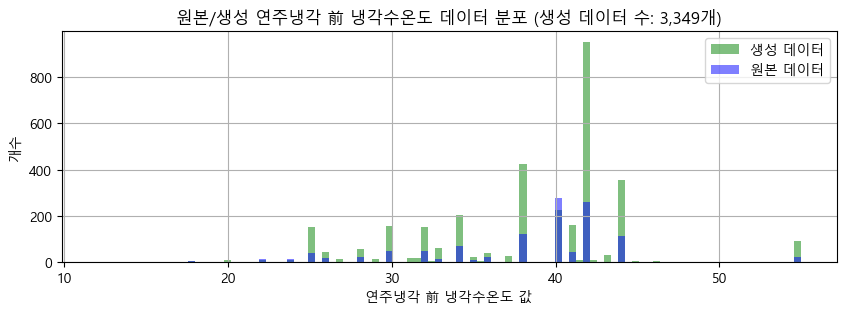

<Figure size 640x480 with 0 Axes>

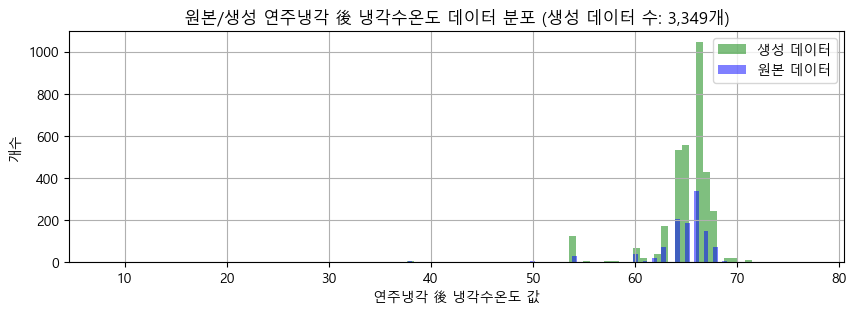

<Figure size 640x480 with 0 Axes>

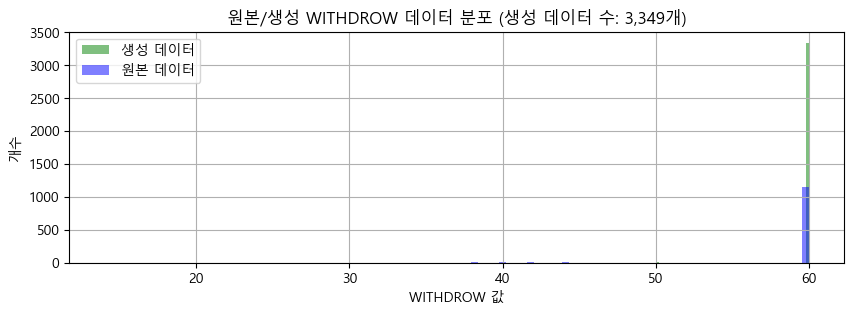

<Figure size 640x480 with 0 Axes>

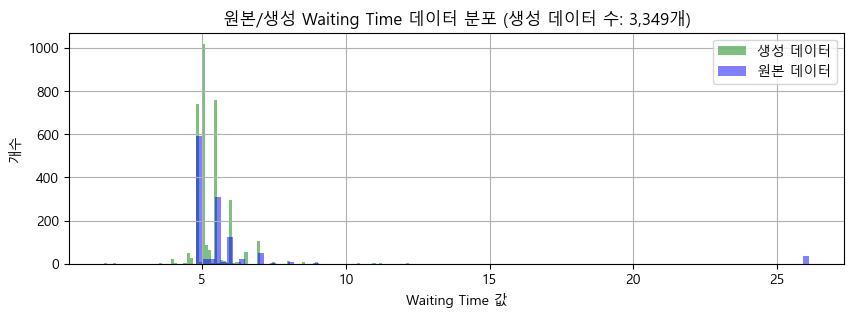

<Figure size 640x480 with 0 Axes>

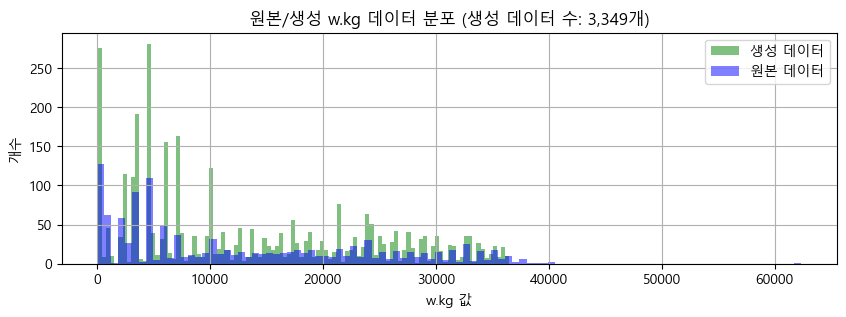

<Figure size 640x480 with 0 Axes>

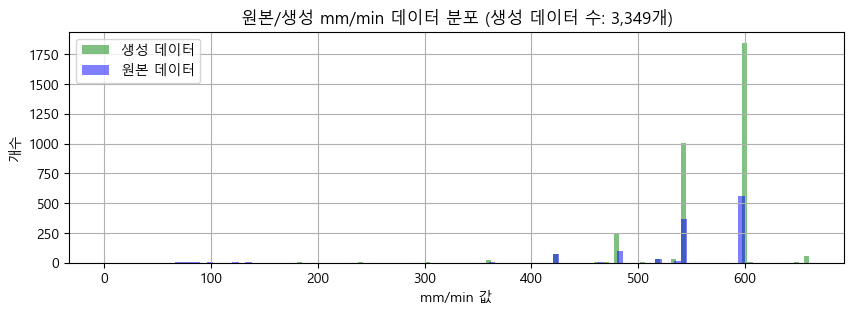

<Figure size 640x480 with 0 Axes>

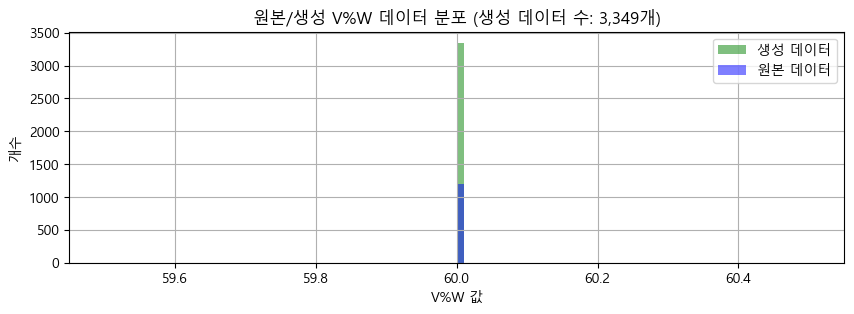

<Figure size 640x480 with 0 Axes>

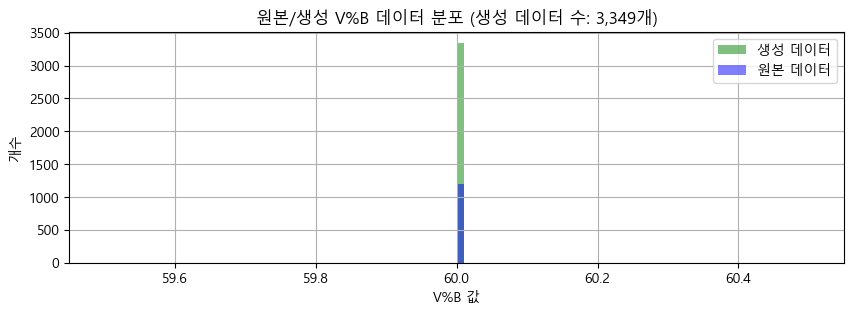

<Figure size 640x480 with 0 Axes>

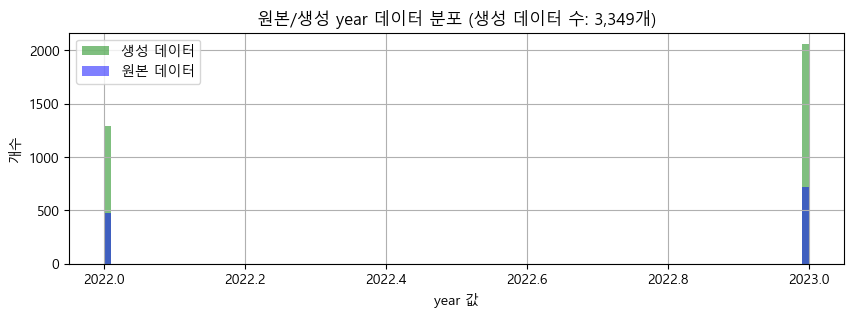

<Figure size 640x480 with 0 Axes>

In [10]:
tar_cols = fin_data_df.columns.tolist()[1:]

for tar_col in tar_cols:
    fig = plt.figure(figsize=(10,3))
    gen_nor_df[tar_col].hist(bins=100, alpha=0.5, color='g')
    ori_data_df[tar_col].hist(bins=100, alpha=0.5, color='b')

    # plt.ylim(0,(len(ori_data_df[tar_col])//500+1)*500)
    plt.xlabel(tar_col+" 값")
    plt.ylabel('개수')
    plt.legend(['생성 데이터', '원본 데이터'])
    plt.title(f'원본/생성 {tar_col} 데이터 분포 (생성 데이터 수: {len(gen_nor_df):,}개)')
    plt.show()
    plt.clf()


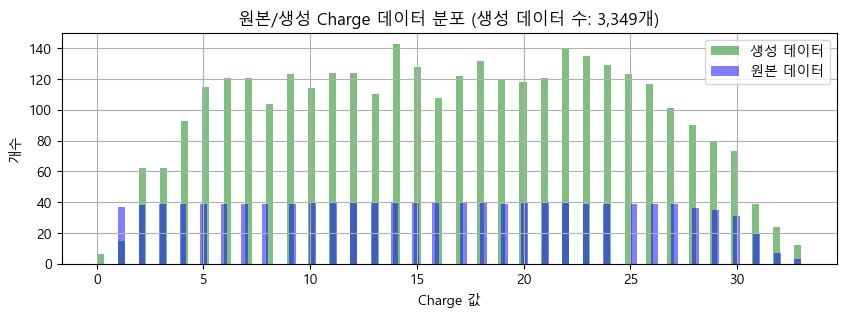

<Figure size 640x480 with 0 Axes>

In [6]:
tar_cols = fin_data_df.columns.tolist()[1:]

tar_col = tar_cols[0]
fig = plt.figure(figsize=(10,3))
gen_nor_df[tar_col].hist(bins=100, alpha=0.5, color='g')
ori_data_df[tar_col].hist(bins=100, alpha=0.5, color='b')

# plt.ylim(0,(len(ori_data_df[tar_col])//500+1)*500)
plt.xlabel(tar_col+" 값")
plt.ylabel('개수')
plt.legend(['생성 데이터', '원본 데이터'])
plt.title(f'원본/생성 {tar_col} 데이터 분포 (생성 데이터 수: {len(gen_nor_df):,}개)')
plt.show()
plt.clf()


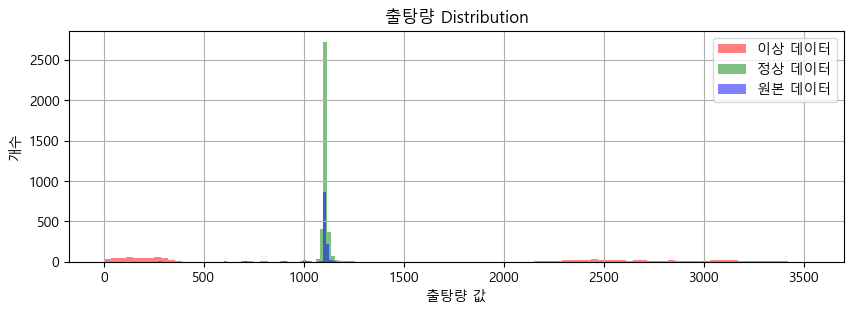

<Figure size 640x480 with 0 Axes>

In [57]:
tar_cols = fin_data_df.columns.tolist()[1:]

tar_col = tar_cols[1]
fig = plt.figure(figsize=(10,3))
gen_out_df[tar_col].hist(bins=100, alpha=0.5, color='r')
gen_nor_df[tar_col].hist(bins=50, alpha=0.5, color='g')
ori_data_df[tar_col].hist(bins=50, alpha=0.5, color='b')
plt.xlabel(tar_col+" 값")
plt.ylabel('개수')
plt.legend(['이상 데이터', '정상 데이터', '원본 데이터'])
plt.title(f'{tar_col} Distribution')
plt.show()
plt.clf()


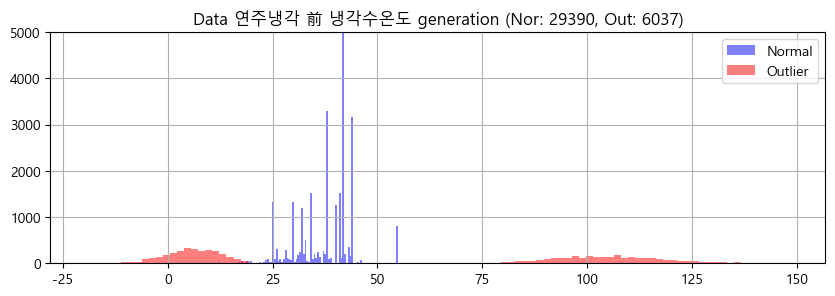

<Figure size 640x480 with 0 Axes>

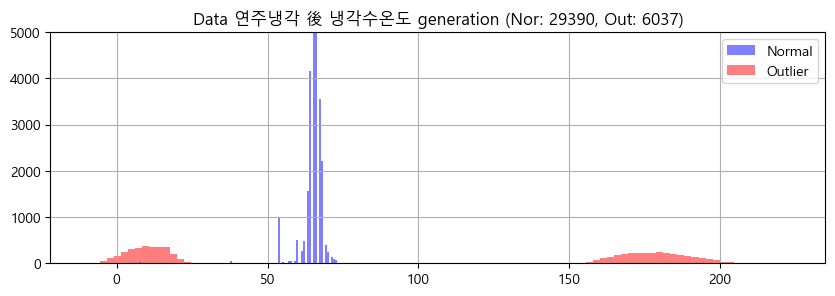

<Figure size 640x480 with 0 Axes>

In [41]:
tar_cols = ['연주냉각 前 냉각수온도','연주냉각 後 냉각수온도']

bin_num = 100
alpha_val = 0.5

tar_col = tar_cols[0]
fig = plt.figure(figsize=(10,3))
tmp_data_df[tar_col].hist(bins=bin_num, alpha=alpha_val, color='b')
new_out_df[tar_col].hist(bins=bin_num, alpha=alpha_val, color='r')
plt.ylim(0, 5000)
plt.legend(['Normal', 'Outlier'])
plt.title(f'Data {tar_col} generation (Nor: {len(tmp_data_df)}, Out: {len(new_out_df)})')
plt.show()
plt.clf()

tar_col = tar_cols[1]
fig = plt.figure(figsize=(10,3))
tmp_data_df[tar_col].hist(bins=bin_num, alpha=alpha_val, color='b')
new_out_df[tar_col].hist(bins=bin_num, alpha=alpha_val, color='r')
plt.ylim(0, 5000)
plt.legend(['Normal generation', 'Outlier generation'])
plt.title(f'Data {tar_col} generation (Nor: {len(tmp_data_df)}, Out: {len(new_out_df)})')
plt.show()
plt.clf()


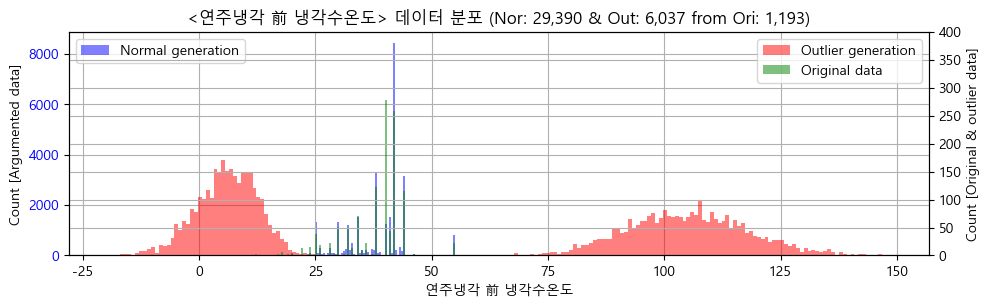

<Figure size 640x480 with 0 Axes>

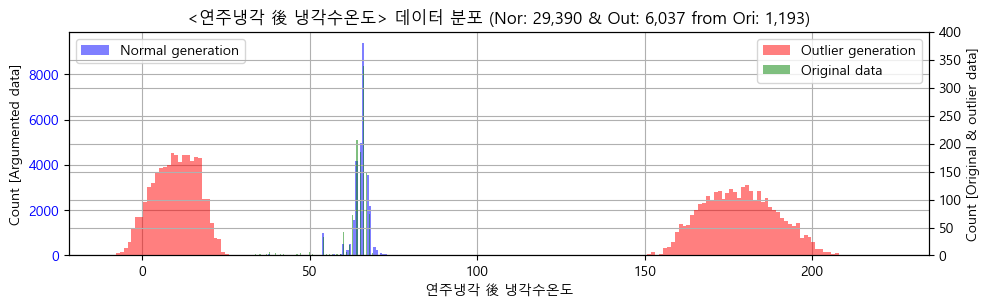

<Figure size 640x480 with 0 Axes>

In [39]:
original_df = pd.read_csv('./New_Data/Merged_original_dataset.csv')

tar_cols = ['연주냉각 前 냉각수온도','연주냉각 後 냉각수온도']

bin_num = 100
alpha_val = 0.5

tar_col = tar_cols[0]
fig, ax1 = plt.subplots(figsize=(10,3))
ax1.set_xlabel(tar_col)
ax1.set_ylabel('Count [Argumented data]')
ax1.tick_params(axis='y', labelcolor='b')
tmp_data_df[tar_col].hist(ax=ax1, bins=100, alpha=alpha_val, color='b')
ax1.legend(['Normal generation'], loc=2)
ax2 = ax1.twinx()
ax2.set_xlabel(tar_col)
ax2.set_ylabel('Count [Original & outlier data]')
ax2.set_ylim(0, 400)
new_out_df[tar_col].hist(ax=ax2, bins=200, alpha=alpha_val, color='r')
original_df[tar_col].hist(ax=ax2, bins=100, alpha=alpha_val, color='g')
ax2.legend(['Outlier generation', 'Original data'], loc=0)
fig.tight_layout()
plt.title(f'<{tar_col}> 데이터 분포 (Nor: {len(tmp_data_df):,} & Out: {len(new_out_df):,} from Ori: {len(original_df):,})')
plt.show()
plt.clf()

tar_col = tar_cols[1]
fig, ax1 = plt.subplots(figsize=(10,3))
ax1.set_xlabel(tar_col)
ax1.set_ylabel('Count [Argumented data]')
ax1.tick_params(axis='y', labelcolor='b')
tmp_data_df[tar_col].hist(ax=ax1, bins=100, alpha=alpha_val, color='b')
ax1.legend(['Normal generation'], loc=2)
ax2 = ax1.twinx()
ax2.set_xlabel(tar_col)
ax2.set_ylabel('Count [Original & outlier data]')
ax2.set_ylim(0, 400)
new_out_df[tar_col].hist(ax=ax2, bins=200, alpha=alpha_val, color='r')
original_df[tar_col].hist(ax=ax2, bins=100, alpha=alpha_val, color='g')
ax2.legend(['Outlier generation', 'Original data'], loc=0)
fig.tight_layout()
plt.title(f'<{tar_col}> 데이터 분포 (Nor: {len(tmp_data_df):,} & Out: {len(new_out_df):,} from Ori: {len(original_df):,})')
plt.show()
plt.clf()


In [ ]:
whole_df

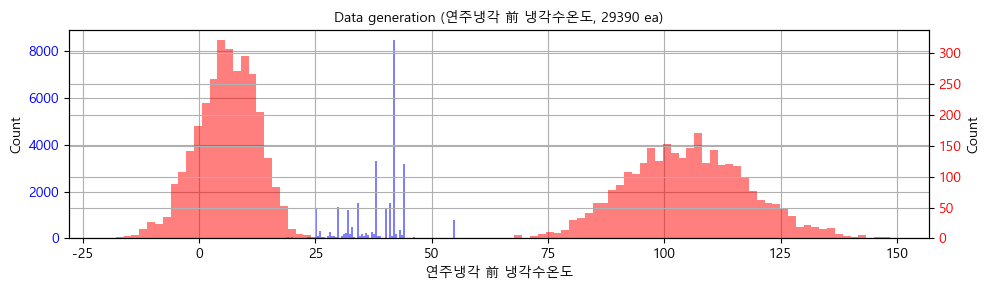

<Figure size 640x480 with 0 Axes>

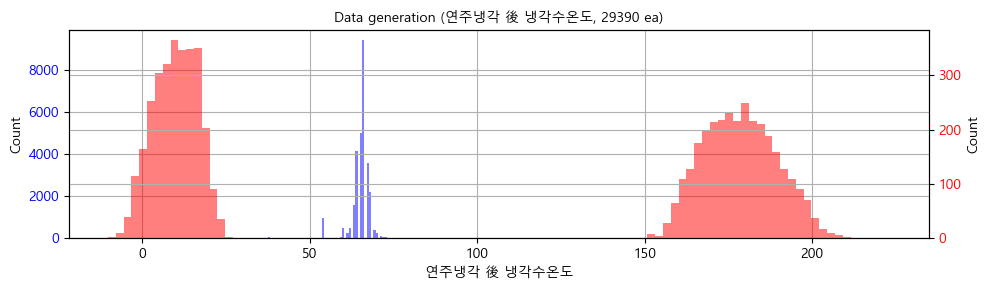

<Figure size 640x480 with 0 Axes>

In [38]:
tar_cols = ['연주냉각 前 냉각수온도','연주냉각 後 냉각수온도']

tar_col = tar_cols[0]
fig, ax1 = plt.subplots(figsize=(10,3))
ax1.set_xlabel(tar_col)
ax1.set_ylabel('Count')
ax1.tick_params(axis='y', labelcolor='b')
tmp_data_df[tar_col].hist(ax=ax1, bins=100, alpha=0.5, color="b")

ax2 = ax1.twinx()
ax2.set_xlabel(tar_col)
ax2.set_ylabel('Count')
ax2.tick_params(axis='y', labelcolor='r')
new_out_df[tar_col].hist(ax=ax2, bins=100, alpha=0.5, color="r")

plt.title(f'Data generation ({tar_col}, {len(tmp_data_df)} ea)', size = 10)
fig.tight_layout()
plt.show()
plt.clf()

tar_col = tar_cols[1]
fig, ax1 = plt.subplots(figsize=(10,3))
ax1.set_xlabel(tar_col)
ax1.set_ylabel('Count')
ax1.tick_params(axis='y', labelcolor='b')
tmp_data_df[tar_col].hist(ax=ax1, bins=100, alpha=0.5, color="b")

ax2 = ax1.twinx()
ax2.set_xlabel(tar_col)
ax2.set_ylabel('Count')
ax2.tick_params(axis='y', labelcolor='r')
new_out_df[tar_col].hist(ax=ax2, bins=100, alpha=0.5, color="r")

plt.title(f'Data generation ({tar_col}, {len(tmp_data_df)} ea)', size = 10)
fig.tight_layout()
plt.show()
plt.clf()


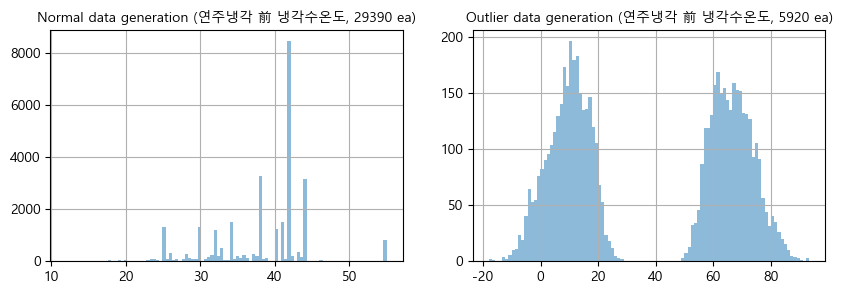

<Figure size 640x480 with 0 Axes>

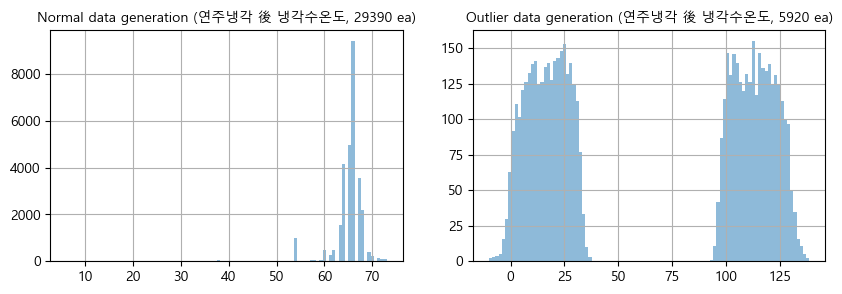

<Figure size 640x480 with 0 Axes>

In [6]:
tar_cols = ['연주냉각 前 냉각수온도','연주냉각 後 냉각수온도']

tar_col = tar_cols[0]
fig = plt.figure(figsize=(10,3))
ax=fig.add_subplot(1,2,1)
ax.set_title(f'Normal data generation ({tar_col}, {len(tmp_data_df)} ea)', size = 10)
tmp_data_df[tar_col].hist(ax=ax, bins=100, alpha=0.5)
ax=fig.add_subplot(1,2,2)
ax.set_title(f'Outlier data generation ({tar_col}, {len(new_out_df)} ea)', size = 10)
new_out_df[tar_col].hist(ax=ax, bins=100, alpha=0.5)
plt.show()
plt.clf()

tar_col = tar_cols[1]
fig = plt.figure(figsize=(10,3))
ax=fig.add_subplot(1,2,1)
ax.set_title(f'Normal data generation ({tar_col}, {len(tmp_data_df)} ea)', size = 10)
tmp_data_df[tar_col].hist(ax=ax, bins=100, alpha=0.5)
ax=fig.add_subplot(1,2,2)
ax.set_title(f'Outlier data generation ({tar_col}, {len(new_out_df)} ea)', size = 10)
new_out_df[tar_col].hist(ax=ax, bins=100, alpha=0.5)
plt.show()
plt.clf()

30


<Axes: >

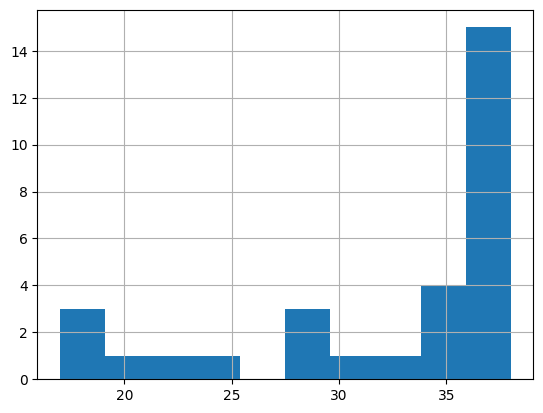

In [ ]:
tar_col = '연주냉각 前 냉각수온도'
print(len(whole_df))
whole_df[tar_col].hist()

### 데이터 증강

100%|██████████| 15/15 [00:00<00:00, 38.54it/s]


192ea at the 1th iteration


100%|██████████| 93/93 [00:02<00:00, 38.86it/s]


1164ea at the 2th iteration


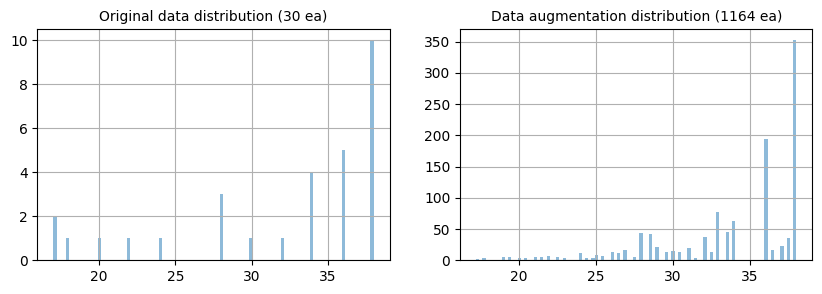

,Charge,출탕량,출탕시간,홀딩로투입시간,실질홀딩로투입온도,실질홀딩로온도,Metal Temp Set,Metal Temp,연주냉각 前 냉각수온도,연주냉각 後 냉각수온도,WITHDROW,Waiting Time,w.kg,mm/min,V%W,V%B,year,month,day,hour,minute,sec
count,30.000000,30.000000,3.000000e+01,3.000000e+01,30.000000,30.00000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0,30.0,30.0,30.0,30.0,30.000000,30.000000,30.0
mean,15.500000,1100.600000,1.673881e+09,1.673882e+09,1325.066667,209.40000,971.366667,968.466667,32.000000,64.566667,59.400000,5.810000,16740.733333,540.866667,60.0,60.0,2023.0,1.0,16.0,14.466667,29.366667,0.0
std,8.803408,19.354408,1.191203e+04,1.193533e+04,1.412587,476.24223,13.207843,15.529135,7.100267,5.568900,3.286335,3.855972,9832.026346,94.045746,0.0,0.0,0.0,0.0,0.0,3.287734,17.802525,0.0
min,1.000000,1004.000000,1.673861e+09,1.673861e+09,1322.000000,0.00000,940.000000,929.000000,17.000000,38.000000,42.000000,4.800000,166.000000,86.000000,60.0,60.0,2023.0,1.0,16.0,9.000000,1.000000,0.0
25%,8.250000,1100.000000,1.673871e+09,1.673872e+09,1324.000000,0.00000,963.500000,960.750000,28.000000,66.000000,60.000000,5.000000,9091.750000,540.000000,60.0,60.0,2023.0,1.0,16.0,12.000000,14.250000,0.0
50%,15.500000,1102.000000,1.673881e+09,1.673882e+09,1325.000000,0.00000,974.500000,972.500000,35.000000,66.000000,60.000000,5.000000,17789.000000,540.000000,60.0,60.0,2023.0,1.0,16.0,14.500000,29.000000,0.0
75%,22.750000,1105.000000,1.673891e+09,1.673891e+09,1326.000000,0.00000,982.000000,981.250000,38.000000,66.000000,60.000000,5.000000,24006.000000,600.000000,60.0,60.0,2023.0,1.0,16.0,17.000000,43.750000,0.0
max,30.000000,1120.000000,1.673900e+09,1.673901e+09,1328.000000,1266.00000,990.000000,986.000000,38.000000,67.000000,60.000000,26.100000,32727.000000,600.000000,60.0,60.0,2023.0,1.0,16.0,20.000000,59.000000,0.0


,Charge,출탕량,출탕시간,홀딩로투입시간,실질홀딩로투입온도,실질홀딩로온도,Metal Temp Set,Metal Temp,연주냉각 前 냉각수온도,연주냉각 後 냉각수온도,WITHDROW,Waiting Time,w.kg,mm/min,V%W,V%B,year,month,day,hour,minute,sec
count,1164.000000,1164.000000,1.164000e+03,1.164000e+03,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.0,1164.000000,1164.000000,1164.000000,1164.0,1164.0,1164.0,1164.0,1164.0,1164.000000,1164.000000,1164.0
mean,16.302405,1101.742268,1.673882e+09,1.673883e+09,1324.946735,148.982818,974.044674,971.868557,33.714562,66.102234,60.0,4.999399,17703.093643,563.195876,60.0,60.0,2023.0,1.0,16.0,14.771478,33.659794,0.0
std,7.221561,11.568060,9.742496e+03,9.665295e+03,2.397817,406.409139,10.914334,11.245364,4.744524,1.324040,0.0,0.243381,7720.499008,33.290603,0.0,0.0,0.0,0.0,0.0,2.757498,21.884935,0.0
min,1.000000,1035.000000,1.673857e+09,1.673859e+09,1312.000000,0.000000,930.000000,913.000000,17.250000,54.000000,60.0,3.600000,1036.000000,360.000000,60.0,60.0,2023.0,1.0,16.0,7.000000,1.000000,0.0
25%,10.000000,1099.000000,1.673875e+09,1.673876e+09,1324.000000,0.000000,968.000000,965.000000,31.000000,66.000000,60.0,5.000000,11572.000000,540.000000,60.0,60.0,2023.0,1.0,16.0,12.000000,14.000000,0.0
50%,16.000000,1102.000000,1.673882e+09,1.673883e+09,1325.000000,0.000000,975.000000,973.000000,36.000000,66.000000,60.0,5.000000,17789.000000,540.000000,60.0,60.0,2023.0,1.0,16.0,15.000000,31.000000,0.0
75%,23.000000,1106.000000,1.673891e+09,1.673892e+09,1326.000000,0.000000,982.000000,982.000000,38.000000,67.000000,60.0,5.000000,24006.000000,600.000000,60.0,60.0,2023.0,1.0,16.0,17.000000,48.000000,0.0
max,31.000000,1134.000000,1.673900e+09,1.673902e+09,1330.000000,1266.000000,998.000000,995.000000,38.000000,69.000000,60.0,6.200000,32727.000000,600.000000,60.0,60.0,2023.0,1.0,16.0,20.000000,86.000000,0.0


<Figure size 640x480 with 0 Axes>

In [ ]:
def remove_max_outliers_IQR(df, col, sen=1.5):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3 - q1
    return df[(df[col] <= (q3+sen*IQR))]

def remove_max_outliers_sigma(df, col, sen=3): # 3시그마 이상치 제거
    # lower_limit = df[col].mean() - (df[col].std()*sen)
    upper_limit = df[col].mean() + (df[col].std()*sen)
    return df[(df[col] <= upper_limit)]

# --------------------------------------
#    Data Augmentation by Oversampling
# --------------------------------------
old_df = whole_df.copy()
tmp_data_df = old_df.copy()

thres = 0.5
overRtio = 1000
underRtio = 100
k_num = 5

data_num = 1000

iter = 1
while len(tmp_data_df) < data_num:
    seed_all(SEED)

    tmp_df = SmoteR(tmp_data_df, target=tar_col, th=thres, o=overRtio, u=underRtio, k=k_num, categorical_col=[])
    tmp_data_df = pd.concat([tmp_data_df, tmp_df], ignore_index=True)
    # 중복 제거    
    tmp_data_df.drop_duplicates(ignore_index=True, inplace=True)

    # 음수 제거 및 IQR 기반 아웃라이어 제거
    for col in tmp_data_df.columns:
        tmp_data_df = tmp_data_df[tmp_data_df[col] >= 0]
        if col != tar_col and tmp_data_df[col].nunique() != 1:
            tmp_data_df = remove_max_outliers_sigma(tmp_data_df, col, 2)

    # Nan 값 제거 
    tmp_data_df.dropna()
    tmp_data_df.reset_index(drop=True, inplace=True)    
    print(f'{len(tmp_data_df)}ea at the {iter}th iteration')
    iter += 1

fig = plt.figure(figsize=(10,3))
ax=fig.add_subplot(1,2,1)
ax.set_title(f'Original data distribution ({len(old_df)} ea)', size = 10)
old_df[tar_col].hist(ax=ax, bins=100, alpha=0.5)
ax=fig.add_subplot(1,2,2)
ax.set_title(f'Data augmentation distribution ({len(tmp_data_df)} ea)', size = 10)
tmp_data_df[tar_col].hist(ax=ax, bins=100, alpha=0.5)
plt.show()
plt.clf()

display(old_df.describe())
display(tmp_data_df.describe())

In [ ]:
# implement SMOTER
def sigmoid(x):
    return 1 / (1 +np.exp(-x))

def relevance(x):
    x = np.array(x)    
    return sigmoid(x)

def get_synth_cases(D, target, o=200, k=3, categorical_col = []):
    '''
    Function to generate the new cases.
    INPUT:
        D - pd.DataFrame with the initial data
        target - string name of the target column in the dataset
        o - oversampling rate
        k - number of nearest neighbors to use for the generation
        categorical_col - list of categorical column names
    OUTPUT:
        new_cases - pd.DataFrame containing new generated cases
    '''
    new_cases = pd.DataFrame(columns = D.columns) # initialize the list of new cases 
    ng = int(o / 100) # the number of new cases to generate
    for index, case in tqdm(D.iterrows(), total=D.shape[0]):
    # for index, case in D.iterrows():
        # find k nearest neighbors of the case
        knn = KNeighborsRegressor(n_neighbors = k+1) # k+1 because the case is the nearest neighbor to itself
        knn.fit(D.drop(columns = [target]).values, D[[target]])
        neighbors = knn.kneighbors(case.drop(labels = [target]).values.reshape(1, -1), return_distance=False).reshape(-1)
        neighbors = np.delete(neighbors, np.where(neighbors == index))
        for i in range(0, ng):
            # randomly choose one of the neighbors
            x = D.iloc[neighbors[np.random.randint(k)]]
            attr = {}          
            for a in D.columns:
                # skip target column
                if a == target:
                    continue
                if a in categorical_col:
                    # if categorical then choose randomly one of values
                    if np.random.randint(2) == 0:
                        attr[a] = case[a]
                    else:
                        attr[a] = x[a]
                else:
                    # if continious column
                    diff = case[a] - x[a]
                    attr[a] = case[a] + np.random.randint(2) * diff
            # decide the target column
            new = np.array(list(attr.values()))
            d1 = cosine_similarity(new.reshape(1, -1), case.drop(labels = [target]).values.reshape(1, -1))[0][0]
            d2 = cosine_similarity(new.reshape(1, -1), x.drop(labels = [target]).values.reshape(1, -1))[0][0]
            attr[target] = (d2 * case[target] + d1 * x[target]) / (d1 + d2)
            
            # append the result
            # new_cases = new_cases.append(attr, ignore_index = True)
            new_cases = pd.concat([new_cases, pd.DataFrame([attr])], ignore_index=True)
    
    return new_cases

def SmoteR(D, target, th = 0.999, o = 200, u = 100, k = 3, categorical_col = []):
    '''
    The implementation of SmoteR algorithm:
    https://core.ac.uk/download/pdf/29202178.pdf
    INPUT:
        D - pd.DataFrame - the initial dataset
        target - the name of the target column in the dataset
        th - relevance threshold
        o - oversampling rate
        u - undersampling rate
        k - the number of nearest neighbors
    OUTPUT:
        new_D - the resulting new dataset
    '''
    # median of the target variable
    y_bar = D[target].median()
    
    # find rare cases where target less than median
    rareL = D[(relevance(D[target]) > th) & (D[target] > y_bar)]  

    # generate rare cases for rareL
    new_casesL = get_synth_cases(rareL, target, o, k , categorical_col)
    
    # find rare cases where target greater than median
    rareH = D[(relevance(D[target]) > th) & (D[target] < y_bar)]
    # generate rare cases for rareH
    new_casesH = get_synth_cases(rareH, target, o, k , categorical_col)
    
    new_cases = pd.concat([new_casesL, new_casesH], axis=0)
    
    # undersample norm cases
    norm_cases = D[relevance(D[target]) <= th]
    # get the number of norm cases
    nr_norm = int(len(norm_cases) * u / 100)
    
    norm_cases = norm_cases.sample(min(len(D[relevance(D[target]) <= th]), nr_norm))
    
    # get the resulting dataset
    new_D = pd.concat([new_cases, norm_cases], axis=0)
    
    return new_D